After testing the effectiveness of using the MODIS product to classify fires from the GFA dataset, this notebook uses MODIS to classify fires in the MTBS and GFD datasets, which do not originally contain a land cover attribute.

In [1]:
import sys
import os
import re
from utils import wildfire_powerlaw as wfpl

sys.path.append("..")
from utils.landcover_segmentation import *

modis_folder = "/Users/lukevonkapff/wildfires/MODIS_USA/GeoTIFF"
modis_files = [os.path.join(modis_folder, f) for f in os.listdir(modis_folder) if f.endswith(".tif")]
modis_by_year = {}
for f in modis_files:
    match = re.search(r"A(\d{4})", os.path.basename(f))
    if match:
        year = int(match.group(1))
        modis_by_year.setdefault(year, []).append(f)

modis_to_gfa = {
    0: "Water",
    1: "Evergreen Needleleaf forest",
    2: "Evergreen Broadleaf forest",
    3: "Deciduous Needleleaf forest",
    4: "Deciduous Broadleaf forest",
    5: "Mixed forest",
    6: "Closed shrublands",
    7: "Open shrublands",
    8: "Woody savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent wetlands",
    12: "Croplands",
    13: "Urban and built-up",
    14: "Cropland/Natural vegetation mosaic",
    15: "Snow and ice",
    16: "Barren or sparsely vegetated"
}

### Classify MTBS

In [2]:
# This call takes a very long time to run--the output is saved in the "data" directory for easy access

# REPLACE WITH PATH TO MTBS DOWNLOADED DATA
mtbs_gdf = load_shapefile(
    "/Users/lukevonkapff/wildfires/MTBS/S_USA.MTBS_BURN_AREA_BOUNDARY.shp",
    "EPSG:4269",
    area_col="AREA_SQKM"
)

mtbs_filtered = mtbs_gdf[mtbs_gdf["AREA_SQKM"] >= 4].copy()
mtbs_filtered = mtbs_filtered.rename(columns={
    "YEAR": "year",
    "AREA_SQKM": "area_km2"
})

mtbs_classified = classify_with_modis(
    mtbs_filtered,
    "year",    
    modis_by_year,
    modis_to_gfa
)

print(f"Classified {len(mtbs_classified)} MTBS fires over 4 km²")
mtbs_classified[["year", "area_km2", "modis_class"]].head()

Classified 25256 MTBS fires over 4 km²


,year,area_km2,modis_class
0,2024,4.994606,Unknown
1,2024,10.170520,Unknown
2,2024,8.490276,Unknown
3,2023,16.290980,Unknown
4,2024,6.573028,Unknown


### Classify Idaho GFD

In [3]:
# REPLACE WITH PATH TO GDF DOWNLOADED DATA
idaho_gdf = gpd.read_file("/Users/lukevonkapff/wildfires/ID_HFDB/HFD_HistoricFiresDatabase7_0.gdb", layer="Fires1950_Present")
idaho_gdf = idaho_gdf.to_crs("EPSG:6933")
idaho_gdf["area_km2"] = idaho_gdf.geometry.area / 1e6

idaho_filtered = idaho_gdf[idaho_gdf["area_km2"] >= 4].copy()
idaho_filtered = idaho_filtered.rename(columns={"FIRE_YEAR": "year"})

idaho_classified = classify_with_modis(idaho_filtered, "year", modis_by_year, modis_to_gfa)

/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiPolygon' is converted to 'MultiPolygon Z'
  return ogr_read(
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [4]:
mtbs_path = "../data/mtbs_2003_2016_classified_timevarying.shp"
mtbs_classified.to_file(mtbs_path)
print(f"Saved GeoDataFrame to {mtbs_path}")

idaho_path = "../data/idaho_2003_2016_classified_timevarying.shp"
idaho_classified.to_file(idaho_path)
print(f"Saved GeoDataFrame to {idaho_path}")

gfa_shp = "../data/gfa_usa_2003_2016_classified.shp"
gfa_classified = gpd.read_file(gfa_shp)

/var/folders/84/1wml2kcs3c97cl37plzqv0kh0000gn/T/ipykernel_4920/934340005.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  mtbs_classified.to_file(mtbs_path)
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'modis_class' to 'modis_clas'
  ogr_write(
/var/folders/84/1wml2kcs3c97cl37plzqv0kh0000gn/T/ipykernel_4920/934340005.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  idaho_classified.to_file(idaho_path)


Saved GeoDataFrame to ../data/mtbs_2003_2016_classified_timevarying.shp


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'FIRE_Number' to 'FIRE_Numbe'
  ogr_write(
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Shape_Length' to 'Shape_Leng'
  ogr_write(
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'modis_class' to 'modis_clas'
  ogr_write(
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 254339831.48735183 of field Shape_Area of feature 3 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 143179620.65255752 of field Shape_Ar

Saved GeoDataFrame to ../data/idaho_2003_2016_classified_timevarying.shp


Now, the following code runs the distribution fitting routine on each land cover type for each dataset.

In [5]:
# If using pre-saved dataframes (from "data" directory), may need to change column names in the next 2 cells to avoid key error

results_gfa = {}

for modis_cat, subset in gfa_classified[(gfa_classified["year"] >= 2003) & (gfa_classified["year"] <= 2016)].groupby("modis_clas"):
    data = subset["area_km2"].values
    
    if len(data) == 0:
        continue
    
    print(f"\n=== {modis_cat} (n={len(data)}) ===")
    
    params = wfpl.summarize_parameters_bootstrap(
        data, R=100, xmin=4, random_state=42
    )
    R, best = wfpl.likelihood_matrix_and_best(
        data, xmin=4
    )
    
    results_gfa[modis_cat] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best
    }

results_idaho = {}

for modis_cat, subset in idaho_classified[(idaho_classified["year"] >= 2003) & (idaho_classified["year"] <= 2016)].groupby("modis_class"):
    data = subset["area_km2"].values
    
    if len(data) == 0:
        continue
    
    print(f"\n=== {modis_cat} (n={len(data)}) ===")
    
    params = wfpl.summarize_parameters_bootstrap(
        data, R=100, xmin=4, random_state=42
    )
    R, best = wfpl.likelihood_matrix_and_best(
        data, xmin=4
    )
    
    results_idaho[modis_cat] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best
    }

results_mtbs = {}

for modis_cat, subset in mtbs_classified[(mtbs_classified["year"] >= 2003) & (mtbs_classified["year"] <= 2016)].groupby("modis_class"):
    data = subset["area_km2"].values
    
    if len(data) == 0:
        continue
    
    print(f"\n=== {modis_cat} (n={len(data)}) ===")
    
    params = wfpl.summarize_parameters_bootstrap(
        data, R=100, xmin=4, random_state=42
    )
    R, best = wfpl.likelihood_matrix_and_best(
        data, xmin=4
    )
    
    results_mtbs[modis_cat] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best
    }


=== Barren or sparsely vegetated (n=35) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:913: RuntimeWarning: divide by zero encountered in scalar divide
  C = 1.0/C
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:865: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_im

there are 35 points above xmin 4.0 km^2

=== Closed shrublands (n=147) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 147 points above xmin 4.0 km^2

=== Croplands (n=6451) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:913: RuntimeWarning: divide by zero encountered in scalar divide
  C = 1.0/C
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:865: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 6451 points above xmin 4.0 km^2

=== Deciduous Broadleaf forest (n=598) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:913: RuntimeWarning: divide by zero encountered in scalar divide
  C = 1.0/C
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:865: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 598 points above xmin 4.0 km^2

=== Evergreen Broadleaf forest (n=427) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 427 points above xmin 4.0 km^2

=== Evergreen Needleleaf forest (n=557) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 557 points above xmin 4.0 km^2

=== Grasslands (n=6147) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 6147 points above xmin 4.0 km^2

=== Mixed forest (n=199) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumu

there are 199 points above xmin 4.0 km^2

=== Open shrublands (n=480) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 480 points above xmin 4.0 km^2

=== Other (n=57) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumu

there are 57 points above xmin 4.0 km^2

=== Savannas (n=2229) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:913: RuntimeWarning: divide by zero encountered in scalar divide
  C = 1.0/C
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:865: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 2229 points above xmin 4.0 km^2

=== Urban and built-up (n=12) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:2253: RuntimeWarning: overflow encountered in multiply
  return (1.0 / self.sigma) * z ** (-(1.0 / self.xi) - 1.0)
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/scipy/optimize/_optimize.py:851: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/lukevonkapff/Desktop/w

there are 12 points above xmin 4.0 km^2

=== Woody savannas (n=2500) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 2500 points above xmin 4.0 km^2

=== Barren or sparsely vegetated (n=3) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:2253: RuntimeWarning: overflow encountered in multiply
  return (1.0 / self.sigma) * z ** (-(1.0 / self.xi) - 1.0)
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/scipy/optimize/_optimize.py:851: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distr

there are 3 points above xmin 4.0 km^2

=== Closed shrublands (n=66) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:913: RuntimeWarning: divide by zero encountered in scalar divide
  C = 1.0/C
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:865: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C


there are 66 points above xmin 4.0 km^2

=== Croplands (n=28) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumu

there are 28 points above xmin 4.0 km^2

=== Evergreen Broadleaf forest (n=9) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:2253: RuntimeWarning: overflow encountered in multiply
  return (1.0 / self.sigma) * z ** (-(1.0 / self.xi) - 1.0)
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/scipy/optimize/_optimize.py:851: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 9 points above xmin 4.0 km^2

=== Evergreen Needleleaf forest (n=349) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 349 points above xmin 4.0 km^2

=== Grasslands (n=2791) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 2791 points above xmin 4.0 km^2

=== Mixed forest (n=1) ===


Not enough data. Returning nan
Not enough data. Returning nan
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:2253: RuntimeWarning: overflow encountered in multiply
  return (1.0 / self.sigma) * z ** (-(1.0 / self.xi) - 1.0)
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/scipy/optimize/_optimize.py:851: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
Not enough data. Returning nan
Not enough data. Returning nan
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-p

there are 1 points above xmin 4.0 km^2

=== Open shrublands (n=316) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 316 points above xmin 4.0 km^2

=== Savannas (n=156) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 156 points above xmin 4.0 km^2

=== Woody savannas (n=511) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 511 points above xmin 4.0 km^2

=== Barren or sparsely vegetated (n=2) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:2253: RuntimeWarning: overflow encountered in multiply
  return (1.0 / self.sigma) * z ** (-(1.0 / self.xi) - 1.0)
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/scipy/optimize/_optimize.py:851: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:2253: RuntimeWarning: overflow encountered in multiply
  retur

there are 2 points above xmin 4.0 km^2

=== Closed shrublands (n=73) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/lukevonkap

there are 73 points above xmin 4.0 km^2

=== Cropland/Natural vegetation mosaic (n=3) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:2253: RuntimeWarning: overflow encountered in multiply
  return (1.0 / self.sigma) * z ** (-(1.0 / self.xi) - 1.0)
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/scipy/optimize/_optimize.py:851: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


there are 3 points above xmin 4.0 km^2

=== Croplands (n=113) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/lukevonkap

there are 113 points above xmin 4.0 km^2

=== Deciduous Broadleaf forest (n=754) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 754 points above xmin 4.0 km^2

=== Evergreen Broadleaf forest (n=726) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 726 points above xmin 4.0 km^2

=== Evergreen Needleleaf forest (n=582) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 582 points above xmin 4.0 km^2

=== Grasslands (n=4009) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 4009 points above xmin 4.0 km^2

=== Mixed forest (n=562) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:913: RuntimeWarning: divide by zero encountered in scalar divide
  C = 1.0/C
/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:865: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 562 points above xmin 4.0 km^2

=== Open shrublands (n=516) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 516 points above xmin 4.0 km^2

=== Permanent wetlands (n=93) ===


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 93 points above xmin 4.0 km^2

=== Savannas (n=1417) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumu

there are 1417 points above xmin 4.0 km^2

=== Unknown (n=17) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:2253: RuntimeWarning: overflow encountered in multiply
  return (1.0 / self.sigma) * z ** (-(1.0 / self.xi) - 1.0)
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/scipy/optimize/_optimize.py:851: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 17 points above xmin 4.0 km^2

=== Woody savannas (n=2158) ===


/Users/lukevonkapff/Desktop/wildfire_powerlaw/wildfire_powerlaw/powerlaw.py:1653: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumu

there are 2158 points above xmin 4.0 km^2


In [6]:
results_dicts = {
    "GFA": results_gfa,
    "Idaho": results_idaho,
    "MTBS": results_mtbs
}

counts_dicts = {
    "GFA": gfa_classified[(gfa_classified["year"].between(2003,2016)) & (gfa_classified["area_km2"]>=4)]["modis_clas"].value_counts(),
    "Idaho": idaho_classified[(idaho_classified["year"].between(2003,2016)) & (idaho_classified["area_km2"]>=4)]["modis_class"].value_counts(),
    "MTBS": mtbs_classified[(mtbs_classified["year"].between(2003,2016)) & (mtbs_classified["area_km2"]>=4)]["modis_class"].value_counts(),
}

build_comparison_table(results_dicts, counts_dicts)

,modis_class,MTBS_n,MTBS_fit,MTBS_loglik,MTBS_reduces_to,GFA_n,GFA_fit,GFA_loglik,GFA_reduces_to,Idaho_n,Idaho_fit,Idaho_loglik,Idaho_reduces_to
0,Croplands,,,,,6451,lognormal,,,,,,
1,,,,,,,stretched_exponential,0.398,,,,,
2,,,,,,,weibull,0.398,,,,,
3,,,,,,,generalized_pareto,1.795,,,,,
4,Deciduous Broadleaf forest,754,lognormal,0.61,,,,,,,,,
5,Evergreen Needleleaf forest,582,truncated_power_law,,,557,truncated_power_law,,,,,,
6,Grasslands,4009,lognormal,,,6147,lognormal,0.996,,,,,
7,Open shrublands,516,lognormal,,,480,lognormal,0.351,,,,,
8,,,weibull,0.082,,,truncated_power_law,1.709,,,,,
9,Savannas,1417,truncated_power_law,,,2229,generalized_pareto,,,,,,


The following function visualizes the "good" fits in parameter space for a all datasets and land cover types.

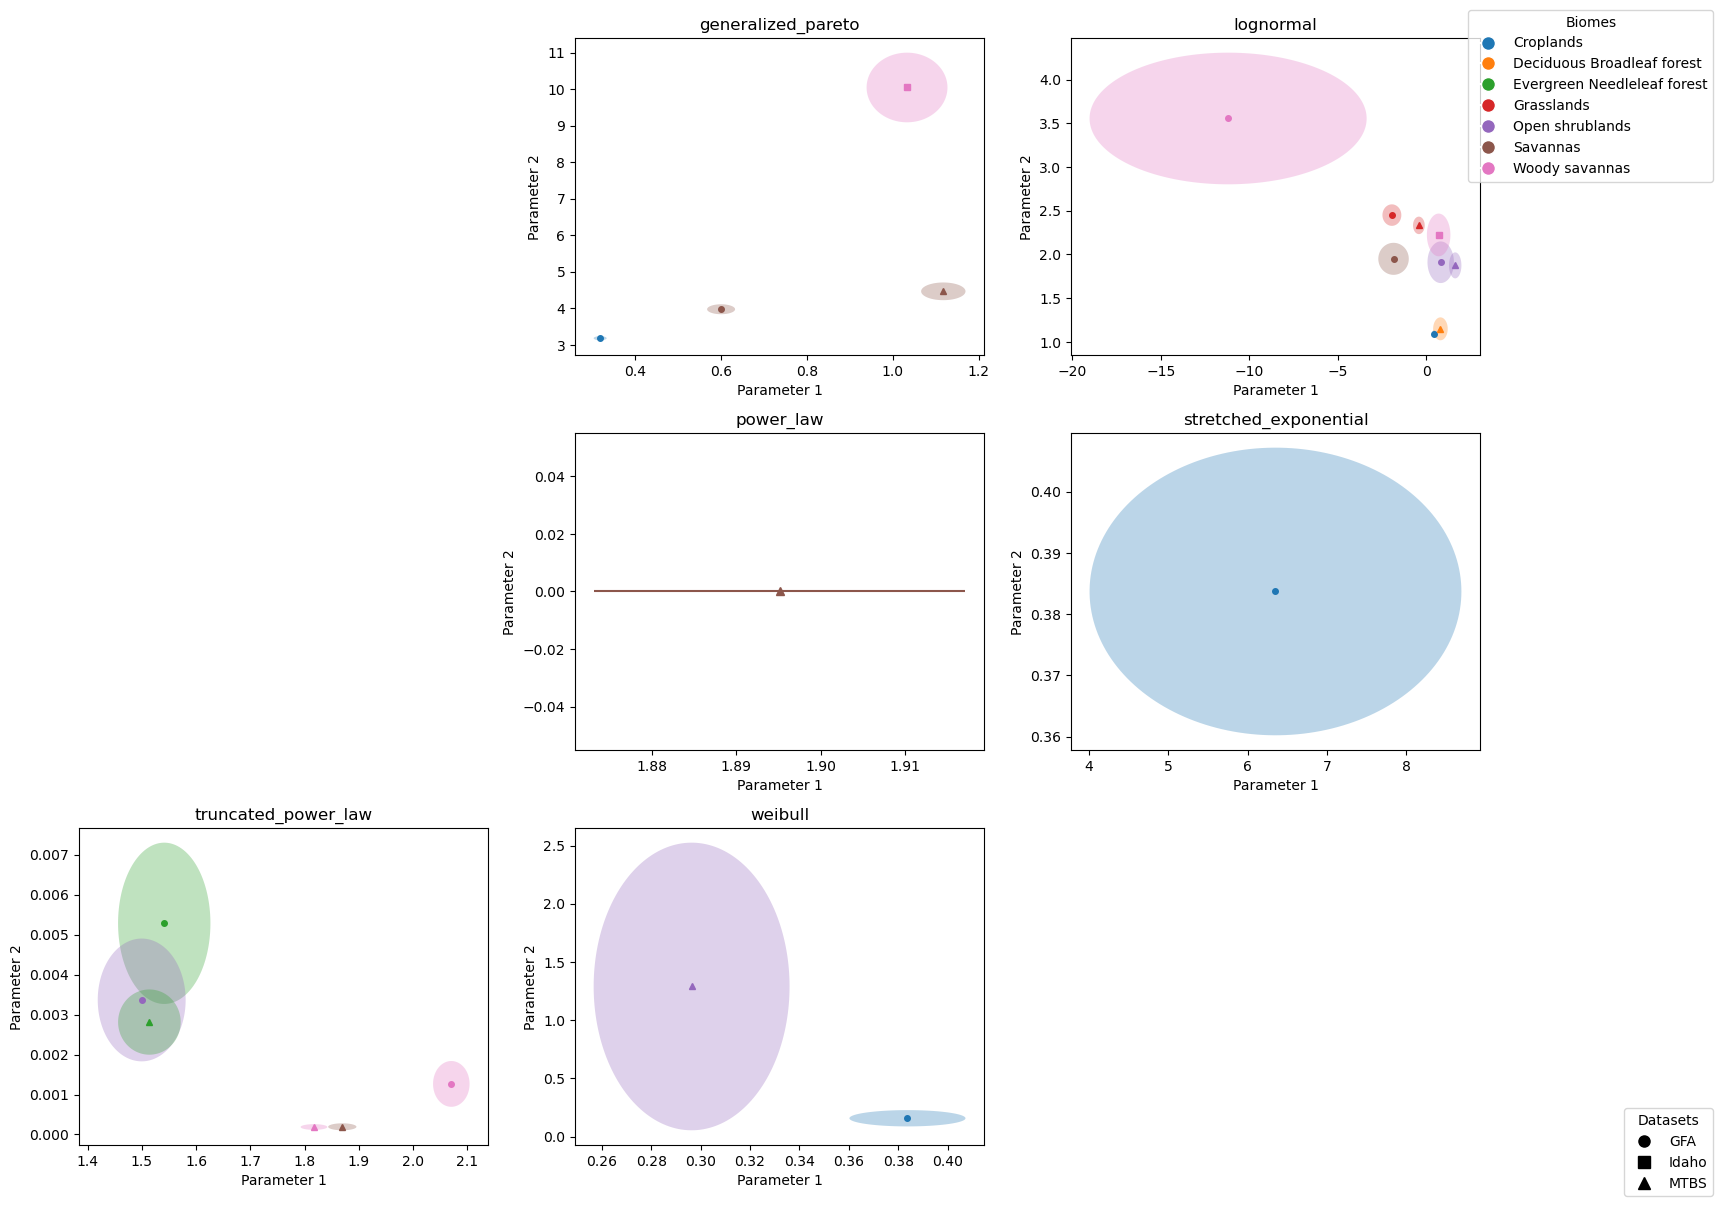

In [7]:
plot_distribution_params(results_dicts, counts_dicts, min_count=400, llhr_cutoff=2, log_axes=False, max_rel_error=1)

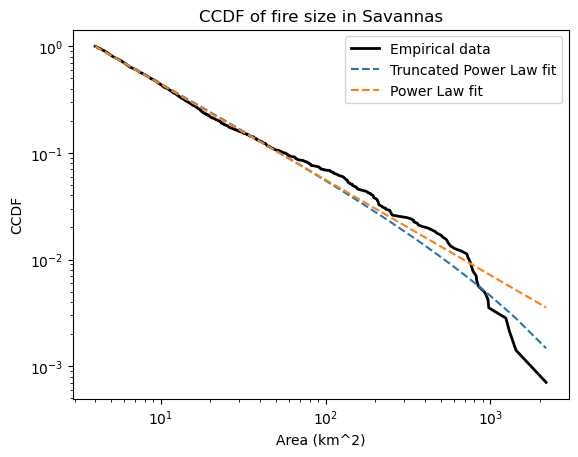

<Axes: title={'center': 'CCDF of fire size in Savannas'}, xlabel='Area (km^2)', ylabel='CCDF'>

In [9]:
plot_modis_category_ccdf(mtbs_classified, "Savannas", xmin=4, which=["truncated_power_law", "power_law"])